---
# О вкусной и здоровой пище...
---
Проект 3 

## Постановка задачи:
Представьте, что вы работаете DS в компании TripAdvisor. Одна из проблем компании — это нечестные рестораны, которые накручивают себе рейтинг. Одним из способов нахождения таких ресторанов является построение модели, которая предсказывает рейтинг ресторана. Если предсказания модели сильно отличаются от фактического результата, то, возможно, ресторан играет нечестно, и его стоит проверить.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
import warnings
import random
import re
import math

warnings.simplefilter('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

## Функции для анализа и прогноза

In [2]:
from sklearn.model_selection import train_test_split # специальный инструмент для разбивки
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

rand_seed = 42

def mae_test (dataframe, target = 'rating'):
    
    # разделим датасет на части "Тренировочную" и "тестовою" по вектору "train"
    train_data = dataframe.query('train == 1').drop(['train'], axis=1)
    test_data = dataframe.query('train == 0').drop(['train'], axis=1)
    
    
    X = train_data.drop([target],axis=1)          # Тренировочный "Х"
    y = train_data['rating']                      # Тренировочный "y"
    
    X_t = test_data.drop([target],axis=1)         # тестовый "Х"
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand_seed)


    regr = RandomForestRegressor(n_estimators=100, random_state=rand_seed) # Создаем модель
    regr.fit(X_train, y_train)                     # Тренируем модель
    y_pred = regr.predict(X_test)                  # Предсказываем по тренировочному датасету

    y_t_pred = regr.predict(X_t)                   # Предсказываем по тестовому датасету


    # Выводим результат сравнения предсказания и теста
    mae = metrics.mean_absolute_error(y_test, y_pred)

    # функция "округления" результата прогноза до 0.5. 
    # так как модель считает до 3 знаков после запятой, точная ошибка будет больше,
    # чем она есть по смыслу (целевая переменная у нас дискретная с шагом 0.5).
    # Таким образом, это округление не читерство!
    def predict_rounder(y_pred):
        return [(round(y/0.5)*0.5) for y in y_pred]
    
    # забираем векторы для округления
    y_pred_rounded = predict_rounder(y_pred)
    y_t_pred_rounded = predict_rounder(y_t_pred)
    
    # добавляем в тестовый датасет предсказанный рейтинг
    test_data['rating'] = y_t_pred_rounded
        
    # результат предсказания теста после окруления реальных результатаов
    mae_r = metrics.mean_absolute_error(y_test, y_pred_rounded)
    
    # рсчет размера окна для вывода графика влияния векторов на итоговый прогноз 
    # (чтобы много места не занимал, когда векторов мало)
    h_ax = len(X.columns)//2 if len(X.columns) < 14 else 7
    
    # вывод графика влияния векторов
    plt.rcParams['figure.figsize'] = (10,h_ax)
    feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')
        
    # возврат значений МАЕ в рузельтат функции
    return mae, mae_r, test_data


In [3]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (24, 4))
    sns.boxplot(x=column, y='rating', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index)],
               ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [4]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'rating'], 
                        df.loc[df.loc[:, column] == comb[1], 'rating'], nan_policy='omit').pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [5]:
def dum_on(dataframe, column):
    dum = pd.get_dummies(dataframe[column], prefix=column[:2])
    return dataframe.join(dum)

In [6]:
def test_vector(dataframe, list_to_drop):
    # копируем таблицу и создаем списки векторов
    data = dataframe.copy()

    list_col = data.columns.tolist()                                                    # все векторы
    list_obj = data.select_dtypes(include=['object', 'datetime64']).columns.to_list()   # векторы не числовые
    list_drop = list_to_drop                                                            # векторы для удаления вручную
    
    # создаем итоговый векторов для модели
    list_mae = list(set(list_col) - set(list_obj) - set(list_drop))
    list_mae = sorted(list_mae)
    list_mae.remove('rating')
    list_mae.append('rating')                                                           # вектор "рейтинг" ставим в конце
    
    # для удобства отображения делим веткор для модели на части и перобразум в таблицу.
    cut_list = lambda list_mae: [list_mae[i:i+10] for i in range(0, len(list_mae), 10)]
    name_list = lambda nom: ["MAE_"+ str(i) for i in range(0,math.ceil(nom/10))]
    df_mae = pd.DataFrame(cut_list(list_mae)).T
    df_mae.columns = name_list(len(list_mae))
    
    # объединим все векторы в таблицу, чтобы прилично вывести ее на экран и выводим на экран
    show_tab = pd.concat([pd.Series(list_obj, name='object'),
                          pd.Series(list_drop, name='drop'),
                          df_mae], axis=1)
    show_tab.fillna('', inplace=True)
    display(show_tab)
    
    # Вывод на экран значений МАЕ
    mae, mae_round, test_data = mae_test(data[list_mae])
    print(f' MAE : {mae}, MAE_rounded: {mae_round}')

In [7]:
def corr_heat(data, list_drop = []):
    # функция построения таблицы-графика корреляции для наглядности

    # разделим датасет на части "Тренировочную" и "тестовою" по вектору "train"
    test_data = data.query('train == 0').drop(['train'], axis=1)
    data = data.query('train == 1').drop(['train'], axis=1)
        
    list_col = data.columns.tolist()                                                    # все векторы
    list_obj = data.select_dtypes(include=['object', 'datetime64']).columns.to_list()   # векторы не числовые
    #    list_drop                                                                      # векторы для удаления вручную
    
    # создаем итоговый векторов для модели
    list_mae = list(set(list_col) - set(list_obj) - set(['train']) - set(list_drop))
    list_mae = sorted(list_mae)
    list_mae.remove('rating')
    list_mae.append('rating')                                                           # вектор "рейтинг" ставим в конце
   
    # рисование графика 
    cor = data[list_mae].corr()
    plt.figure(figsize=(16,6)) # размер графика
    cm3 = sns.diverging_palette(10, 10, sep=10, center='light', as_cmap=True)
    sns.heatmap(data=cor, annot=True, vmin=-1, vmax=1, center=0, cmap=cm3, linewidths=0.1)
    

- - -  
### 1. Загружаем датасет и форматируем структуру  
- - -   

In [8]:

df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')

df_train['train'] = 1 # помечаем где у нас трейн
df_test['train'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем

# Загружаем датасет
#df = pd.read_csv('main_task_new.csv')
# Приведем названия колонок к нормальному виду: все буквы строчные, пробелы - заменяем на "_"
df.columns = [i.lower() for i in df.columns]
df.columns = [i.replace(' ','_') for i in df.columns]
df.rename({'number_of_reviews': 'reviews_num'}, inplace=True, axis=1)  # укорачиваю длинное название с двумя пробелами

#### Векторы  
**restaurant_id** — идентификационный номер ресторана / сети ресторанов;  
**city** — город, в котором находится ресторан;  
**cuisine_style** — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;  
**ranking** — место, которое занимает данный ресторан среди всех ресторанов своего города;  
**rating** — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);  
**price_range** — диапазон цен в ресторане;  
**reviews_num** — количество отзывов о ресторане;  
**reviews** — данные о двух отзывах, которые отображаются на сайте ресторана;  
**url_ta** — URL страницы ресторана на TripAdvisor;  
**id_ta** — идентификатор ресторана в базе данных TripAdvisor.  

In [9]:
# переставлю местами векторы, чтобы было удобнее работать
df = df[['restaurant_id', 'id_ta', 
         'city', 
         'cuisine_style', 
         'price_range', 
         'reviews_num', 'reviews', 
         'url_ta', 'ranking', 
         'rating', 'train' ]]

In [10]:
df.isna().sum()

restaurant_id        0
id_ta                0
city                 0
cuisine_style    11590
price_range      17361
reviews_num       3200
reviews              2
url_ta               0
ranking              0
rating               0
train                0
dtype: int64

In [11]:
# В датасете есть три вектора с пропусками. Для начала просто сохраним для информции записи, где они присутствуют
df['no_revies'] = df.reviews_num.apply(pd.isna).astype(np.uint8)
df['no_prices'] = df.price_range.apply(pd.isna).astype(np.uint8)
df['no_styles'] = df.cuisine_style.apply(pd.isna).astype(np.uint8)

- - -  
### 2.1. Два вектора ID  
- - -   
#### Дубликат id_ta  

В датасете есть два вектора с ID номерами. Но нам интересен только один - id_ta. Это код "Трип-Эдвайзера" для ресторана. И он, по идее, должен быть уникальным.  
По опыту своей работы я очень трепетно отношусь ко всякого рода ID. Для меня это - уникальные идентификаторы и дублирование их не допустимо. Если же в векторе, озаглавленном ID, есть дубликаты - это повод очень серьезно задуматься и решить, что с ними делать, чтобы дублей не было.  
Проверим **id_ta**, и выясним, что эти ID дублируюутся!!!

In [52]:
# получим словарь со списком ресторанов, продублированными в датасете
all_codes = df.id_ta.value_counts().to_dict()
codes_ta = {key: all_codes[key] for key in all_codes if all_codes[key] > 1}
codes_ta

{'d697406': 2,
 'd7342803': 2,
 'd8753348': 2,
 'd7809594': 2,
 'd2360290': 2,
 'd12488993': 2,
 'd3161682': 2,
 'd10316215': 2,
 'd1315077': 2,
 'd1235635': 2,
 'd9802625': 2,
 'd4600226': 2,
 'd1568045': 2,
 'd1028622': 2,
 'd2477531': 2,
 'd987900': 2,
 'd3396817': 2,
 'd3685055': 2,
 'd793170': 2,
 'd11674463': 2,
 'd9877640': 2,
 'd5618007': 2,
 'd10047799': 2,
 'd2010743': 2,
 'd4748208': 2,
 'd11698990': 2,
 'd5617412': 2,
 'd11921719': 2,
 'd3647024': 2,
 'd11999956': 2,
 'd7827387': 2,
 'd2669414': 2,
 'd10440367': 2,
 'd3748757': 2,
 'd7337366': 2,
 'd13002276': 2,
 'd4914988': 2}

In [63]:
df[(df.id_ta.isin(codes_ta)) & (df.id_ta == 'd1028622')].sort_values(by=['id_ta'])

,restaurant_id,id_ta,city,cuisine_style,price_range,reviews_num,reviews,url_ta,ranking,rating,train,no_revies,no_prices,no_styles
18388,id_1229,d1028622,Madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",$$$$,116.0,"[['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,1231.0,4.0,1,0,0,0
44534,id_4534,d1028622,Madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",$$$$,116.0,"[['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,1253.0,0.0,0,0,0,0


In [62]:
# посмотрим, какая информация в дулях записей дублируется, а какая нет (в таблице - количество уникальных значений)
ddf=df[(df.id_ta.isin(codes_ta))]
ddf.groupby('id_ta')[['restaurant_id', 'city', 'cuisine_style', 'price_range', 
         'reviews_num', 'reviews', 'url_ta', 'ranking', 'rating', 'train']].agg(lambda q: q.nunique())

,restaurant_id,city,cuisine_style,price_range,reviews_num,reviews,url_ta,ranking,rating,train
id_ta,,,,,,,,,,
d10047799,2,1,0,0,1.0,1,1,2.0,1.0,1
d1028622,2,1,1,1,1.0,1,1,2.0,2.0,2
d10316215,2,1,1,1,1.0,1,1,1.0,2.0,2
d10440367,2,1,1,1,1.0,1,1,2.0,2.0,2
d11674463,2,1,1,0,1.0,1,1,2.0,1.0,1
d11698990,2,1,0,0,1.0,1,1,2.0,1.0,1
d11921719,2,1,0,0,1.0,1,1,2.0,1.0,1
d11999956,2,1,1,1,1.0,1,1,2.0,1.0,1
d1235635,2,1,0,0,1.0,1,1,2.0,2.0,2


In [71]:
df['rest_id'] = pd.to_numeric(df.restaurant_id.str.strip('id_'))
df['code_id'] = pd.to_numeric(df.id_ta.str.strip('d'))
df_ = df[df.train == 1]
df_[['code_id', 'rest_id', 'ranking', 'rating']].corr()

,code_id,rest_id,ranking,rating
code_id,1.000000,0.048820,0.048826,0.159111
rest_id,0.048820,1.000000,1.000000,-0.368308
ranking,0.048826,1.000000,1.000000,-0.368371
rating,0.159111,-0.368308,-0.368371,1.000000


In [7]:
# посмотрим на эти записиси
ddf = df[df.id_ta.isin(codes_ta)]        # датасет только с кодами-дублями трип-эдвайзера 
ddf.sort_values(by=['id_ta']).head(6)

,restaurant_id,id_ta,city,cuisine_style,price_range,reviews_num,reviews,url_ta,ranking,rating,no_revies,no_prices,no_styles
38946,id_3242,d10047799,Madrid,NaN,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,3244.0,5.0,0,1,1
13980,id_3239,d10047799,Madrid,NaN,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,3241.0,5.0,0,1,1
11583,id_3810,d11674463,Madrid,"['American', 'German', 'European', 'Central Eu...",NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,3812.0,4.0,0,1,0
4732,id_3804,d11674463,Madrid,"['American', 'German', 'European', 'Central Eu...",NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,3806.0,4.0,0,1,0
26551,id_3240,d11698990,Madrid,NaN,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,3242.0,4.5,0,1,1
26431,id_3238,d11698990,Madrid,NaN,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,3240.0,4.5,0,1,1


In [8]:
# посмотрим, какая информация в дулях записей дублируется, а какая нет (в таблице - количество уникальных значений)
ddf.groupby('id_ta')[['restaurant_id', 'city','cuisine_style','price_range', 'reviews_num', 'reviews', 'url_ta',
                      'ranking', 'rating', 'no_revies', 'no_prices', 'no_styles']].agg(lambda q: q.nunique())

,restaurant_id,city,cuisine_style,price_range,reviews_num,reviews,url_ta,ranking,rating,no_revies,no_prices,no_styles
id_ta,,,,,,,,,,,,
d10047799,2,1,0,0,1.0,1,1,2.0,1.0,1,1,1
d11674463,2,1,1,0,1.0,1,1,2.0,1.0,1,1,1
d11698990,2,1,0,0,1.0,1,1,2.0,1.0,1,1,1
d11921719,2,1,0,0,1.0,1,1,2.0,1.0,1,1,1
d11999956,2,1,1,1,1.0,1,1,2.0,1.0,1,1,1
d13002276,2,1,1,1,1.0,1,1,2.0,1.0,1,1,1
d1315077,2,1,1,1,1.0,1,1,2.0,1.0,1,1,1
d2477531,2,1,1,1,1.0,1,1,2.0,1.0,1,1,1
d3161682,2,1,1,1,1.0,1,1,2.0,1.0,1,1,1


Два значения - это то, чем записи отличаются (**restaurant_id**,**ranking**). И судя по всему, эти дубликаты - смена рестораном собственника, что повлекло смену кода-ресторана и рейтинга.

In [9]:
# словарь с кодами-ресторанов в датасете где с кодами-дублями трип-эдвайзера 
all_codes_r = ddf.restaurant_id.value_counts().to_dict()       
codes_ta_r = {key: all_codes_r[key] for key in all_codes_r}
len(codes_ta_r)

40

In [10]:
# словарь с дублями кодов-ресторанов в оригинале датасета
rest_all_codes = df.restaurant_id.value_counts().to_dict()
rest_codes = {key: rest_all_codes[key] for key in rest_all_codes if rest_all_codes[key] > 1}     # выбираем сетевые рестораны

# сравниваем списки и выясняем, что в 18 из 20 случаев, ресторан был выкуплен сетью. 
# Еще в дух случаях - просто сменил собственника
len(set(rest_codes) & set(codes_ta_r))

36

#### Вывод
Пофакту исследования делаю вывод, что дубликаты **id_ta** вызваны тем, что в датасет попала временнAя динамика ресторанов, скорее всего, рестораны были перепроданы, чаще всего - в сетевую структуру. В связи с чем, с начала  был один рейтинг, а после он изменился (встречается и рост и падение). При этом, надо отметить, что записи идентичны во всех без исключения остальных векторах.  

*Таким образом, я принимаю решение, что запись с бОльшим индексом - более "позняя" и именно ее ранг я должен использовать, а "ранние" нужно исключить из датасета. Несмотря на то, что удаление строк в принципе не являестя допустимым с точки зрения выполнения задания.*

In [11]:
# удалеляем дубликаты записей с одинкавым **id_ta**, осатавив "последний" по номеру, считая
# что это будет более позний по дате установления.
df.drop_duplicates('id_ta', keep='last', inplace=True)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   restaurant_id  50000 non-null  object 
 1   id_ta          50000 non-null  object 
 2   city           50000 non-null  object 
 3   cuisine_style  38410 non-null  object 
 4   price_range    32639 non-null  object 
 5   reviews_num    46800 non-null  float64
 6   reviews        49998 non-null  object 
 7   url_ta         50000 non-null  object 
 8   ranking        50000 non-null  float64
 9   rating         50000 non-null  float64
 10  train          50000 non-null  int64  
 11  no_revies      50000 non-null  uint8  
 12  no_prices      50000 non-null  uint8  
 13  no_styles      50000 non-null  uint8  
dtypes: float64(3), int64(1), object(7), uint8(3)
memory usage: 4.3+ MB


#### Интегрирование id_ta

In [15]:
#df.insert(2,'id_code', 1)

array([1], dtype=int64)

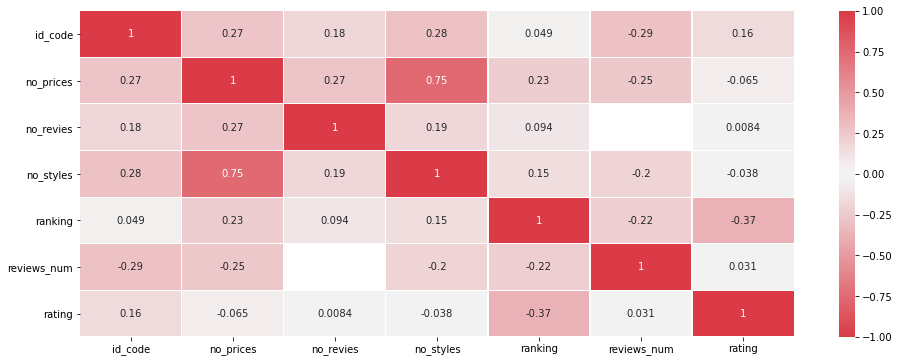

In [16]:
# удалим из кода букву 
df.id_code=pd.to_numeric(df.id_ta.str.strip('d'))
corr_heat(df)
#= pd.to_numeric(df.id_code)

#### Итог
У **id_code** хорошая перспектива полезности для модели. И эта история для меня весьма странная!.. Но, этьо не помешает использовать найденный фактор.
У него есть заметная корреляция с другими, в т.ч. техническими, векторами, но с этим мы разберемся позже.

- - -  
### 2.2. Вектор Country
- - -  
Добавим вектор "Страна", для возможной аггрегации в последствии. Для этого создадим словарь в ручную и используем его для заполнения значениемями вектора.

In [17]:
countries = {      'Paris': 'France', 
               'Stockholm': 'Sweden',
                  'London': 'United Kingdom', 
                  'Berlin': 'Germany', 
                  'Munich': 'Germany',
                 'Oporto' : 'Portugal' ,
                  'Milan' : 'Italy',
             'Bratislava' : 'Slovakia',
                 'Vienna' : 'Austria' ,
                    'Rome': 'Italy',
              'Barcelona' : 'Spain',
                 'Madrid' : 'Spain',
                 'Dublin' : 'Ireland',
               'Brussels' : 'Belgium',
                 'Zurich' : 'Switzerland',
                 'Warsaw' : 'Poland',
               'Budapest' : 'Hungary',
             'Copenhagen' : 'Denmark',
              'Amsterdam' : 'Netherlands',
                   'Lyon' : 'France',
                'Hamburg' : 'Germany',
                 'Lisbon' : 'Portugal',
                 'Prague' : 'Czech Republic',
                   'Oslo' : 'Norway',
               'Helsinki' : 'Finland',
              'Edinburgh' : 'United Kingdom',
                 'Geneva' : 'Switzerland',
              'Ljubljana' : 'Slovenia',
                 'Athens' : 'Greece',
             'Luxembourg' : 'Luxembourg' ,
                  'Krakow': 'Poland'
            }

In [18]:
df.insert(4, 'country', '')

In [19]:
# создадим новый вектор и поставим его по порядку после вектора "город"
df.country = df.city.map(countries)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   restaurant_id  50000 non-null  object 
 1   id_ta          50000 non-null  object 
 2   id_code        50000 non-null  int64  
 3   city           50000 non-null  object 
 4   country        50000 non-null  object 
 5   cuisine_style  38410 non-null  object 
 6   price_range    32639 non-null  object 
 7   reviews_num    46800 non-null  float64
 8   reviews        49998 non-null  object 
 9   url_ta         50000 non-null  object 
 10  ranking        50000 non-null  float64
 11  rating         50000 non-null  float64
 12  train          50000 non-null  int64  
 13  no_revies      50000 non-null  uint8  
 14  no_prices      50000 non-null  uint8  
 15  no_styles      50000 non-null  uint8  
dtypes: float64(3), int64(2), object(8), uint8(3)
memory usage: 5.1+ MB


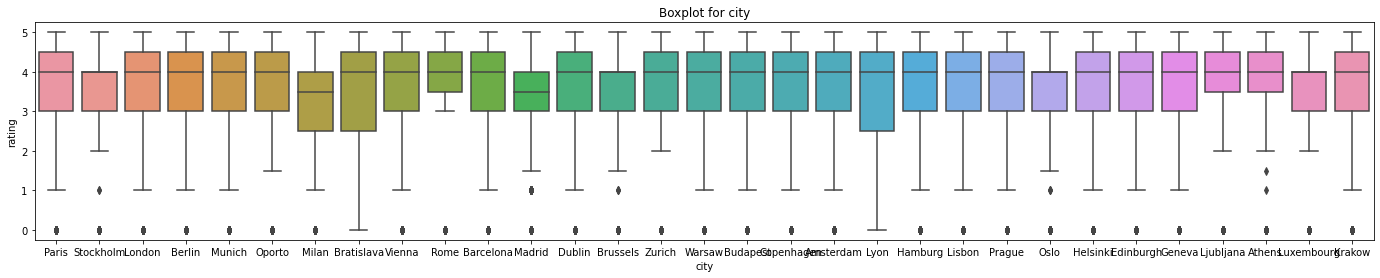

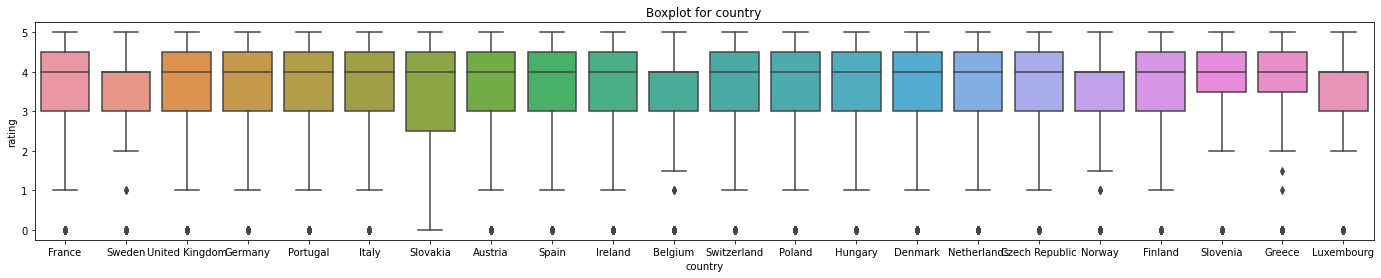

In [20]:
for col in [ 'city', 'country']:
    get_boxplot(col)

In [21]:
for col in [ 'city', 'country']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки city


Два ординарных вектора показывают потенциальную полезность для модели. Проверим позже...

- - - -
### 2.3. Вектор cuisine_style, новый вектор cuisines, заполнение пропусков и FE
- - - -
В этом векторе есть пропуски. Но, для начала, перобразуем данные в полях вектора в списки. Затем, проанализиреум список всех уникальных кухонь. И предлагаю заполнить пропуски в полях теми кухнями, которые являются самыми частыми в этом городе.  

In [29]:
# преобразуем строку из признкака "cuisine_style" в список из названий 
df.cuisine_style = df.cuisine_style.str.replace("'", "")
df.cuisine_style = df.cuisine_style.str.strip('[]')
df.cuisine_style = df.cuisine_style.str.split(', ')

In [30]:
# количество уникальных кухонь (надо отнять 1 так как в списке есть и пропуск, где кухни не заполнены)
len(df.cuisine_style.explode().unique())-1

125

In [31]:
# создадим новый вектор с данным о количестве кухонь. и поместим его перед вектором со списокм кухонь
df.cuisine_style.fillna('', inplace=True)
df.insert(5,'cuisines',0)
df.cuisines = df.cuisine_style.apply(lambda x: 0 if x =='' else len(x))
df.isna().sum()

restaurant_id        0
id_ta                0
id_code              0
city                 0
country              0
cuisines             0
cuisine_style        0
price_range      17361
reviews_num       3200
reviews              2
url_ta               0
ranking              0
rating               0
train                0
no_revies            0
no_prices            0
no_styles            0
dtype: int64

In [32]:
# Среднее значение числа "кухонь" на одно заведение - почти 2.4
df.cuisines.mean()
# Значит, надо будет заполнить не одной какой-то кухней, а как минимум двумя

2.39352

In [33]:
# список всех уникальных кухонь
cuisines_all = df.cuisine_style.explode().sort_values().unique()
cuisines_all

array(['', 'Afghani', 'African', 'Albanian', 'American', 'Arabic',
       'Argentinean', 'Armenian', 'Asian', 'Australian', 'Austrian',
       'Azerbaijani', 'Balti', 'Bangladeshi', 'Bar', 'Barbecue',
       'Belgian', 'Brazilian', 'Brew Pub', 'British', 'Burmese', 'Cafe',
       'Cajun & Creole', 'Cambodian', 'Canadian', 'Caribbean',
       'Caucasian', 'Central American', 'Central Asian',
       'Central European', 'Chilean', 'Chinese', 'Colombian',
       'Contemporary', 'Croatian', 'Cuban', 'Czech', 'Danish',
       'Delicatessen', 'Diner', 'Dutch', 'Eastern European', 'Ecuadorean',
       'Egyptian', 'Ethiopian', 'European', 'Fast Food', 'Filipino',
       'French', 'Fujian', 'Fusion', 'Gastropub', 'Georgian', 'German',
       'Gluten Free Options', 'Greek', 'Grill', 'Halal', 'Hawaiian',
       'Healthy', 'Hungarian', 'Indian', 'Indonesian', 'International',
       'Irish', 'Israeli', 'Italian', 'Jamaican', 'Japanese', 'Korean',
       'Kosher', 'Latin', 'Latvian', 'Lebanese', 'Ma

In [34]:
# самая популярная кухня
df.cuisine_style.explode().value_counts().index[0], df.cuisine_style.explode().value_counts()[0]
# ('Vegetarian Friendly', 11183)

df.cuisine_style.explode().value_counts().iloc[:40]
# 

Vegetarian Friendly    14021
European               12561
                       11590
Mediterranean           7820
Italian                 7433
Vegan Options           5684
Gluten Free Options     5185
Bar                     4094
French                  3970
Asian                   3786
Pizza                   3502
Spanish                 3456
Pub                     3058
Cafe                    2883
Fast Food               2122
British                 1992
International           1966
Seafood                 1878
Japanese                1860
Central European        1727
American                1642
Sushi                   1450
Chinese                 1446
Portuguese              1385
Indian                  1328
Middle Eastern           980
Thai                     923
Wine Bar                 877
German                   820
Halal                    773
Greek                    768
Healthy                  758
Fusion                   748
Czech                    745
Steakhouse    

Переходим к заполнению полей вектора **cuisine_style** в соответстивии с планом. Замечу, что можно было бы затеять более сложный анализ для восстановления этих пропущенных данных. Я обратил внимание, что некоторые отзывы у таких записей содержат намеки на вид кухни ресторана, но такие сведения единичны.
По вектору "город" выберем наиболее частые кухни и заполним этими значениями пропуски.

Хочу отметить, что в списке кухонь есть как, собственно, виды кухонь (национальные, или региональные), так и сервисы или подходы к приготовлению еды (вегетарианская, безглютеновая, веганская, халяль, кошерная), которые можно условно назвать "здоровая" еда, а также можно найти типы заведений, не совсем "рестораны": бар, кафе, пиццерия, закусочная.  
Попробую корректно разделить их в последуюущем

In [35]:
# Создадим словарь из наиболее частых видов кухонь по городам, где это поле заполнено,
#  чтобы заполнить таким жеобразом пропуски
cusines_fill=dict()
for city in df.city.unique():
    temp_dict = df[df.city == city].cuisine_style.explode().value_counts()[:3].to_dict()
    if '' in temp_dict:
        temp_dict.pop('')
    value = list(temp_dict.keys())
    cusines_fill[city]=value
        
cusines_fill

{'Paris': ['French', 'European'],
 'Stockholm': ['European', 'Vegetarian Friendly'],
 'London': ['Vegetarian Friendly', 'British', 'Gluten Free Options'],
 'Berlin': ['Vegetarian Friendly', 'European'],
 'Munich': ['Vegetarian Friendly', 'European'],
 'Oporto': ['Portuguese', 'European', 'Mediterranean'],
 'Milan': ['Italian', 'Vegetarian Friendly'],
 'Bratislava': ['European', 'Central European'],
 'Vienna': ['European', 'Vegetarian Friendly', 'Austrian'],
 'Rome': ['Italian', 'Vegetarian Friendly', 'Mediterranean'],
 'Barcelona': ['Spanish', 'Mediterranean', 'Vegetarian Friendly'],
 'Madrid': ['Spanish', 'Mediterranean'],
 'Dublin': ['Vegetarian Friendly', 'European', 'Irish'],
 'Brussels': ['European', 'Belgian'],
 'Zurich': ['European', 'Vegetarian Friendly'],
 'Warsaw': ['European', 'Vegetarian Friendly'],
 'Budapest': ['European', 'Hungarian', 'Vegetarian Friendly'],
 'Copenhagen': ['European', 'Vegetarian Friendly', 'Danish'],
 'Amsterdam': ['European', 'Vegetarian Friendly', 'D

In [36]:
# создаю временный вектор с данными подстановки из словаря
df['cuisines_l'] = df.city.map(cusines_fill)     
# собираю сведения о кухне из двух векторов в один оригинальный
df['cuisine_style'] = df.apply(lambda q: q['cuisines_l'] if q['no_styles'] == 1 else q['cuisine_style'] , axis=1)
#  заменяю 0 на 1 количества кухонь в векторе в соответствии с тем, что теперь там по 1 кухне есть точно
df.cuisines = df.cuisines.replace(0,3)
# Удаляю временный вектор
df.drop(['cuisines_l'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   restaurant_id  50000 non-null  object 
 1   id_ta          50000 non-null  object 
 2   id_code        50000 non-null  int64  
 3   city           50000 non-null  object 
 4   country        50000 non-null  object 
 5   cuisines       50000 non-null  int64  
 6   cuisine_style  50000 non-null  object 
 7   price_range    32639 non-null  object 
 8   reviews_num    46800 non-null  float64
 9   reviews        49998 non-null  object 
 10  url_ta         50000 non-null  object 
 11  ranking        50000 non-null  float64
 12  rating         50000 non-null  float64
 13  train          50000 non-null  int64  
 14  no_revies      50000 non-null  uint8  
 15  no_prices      50000 non-null  uint8  
 16  no_styles      50000 non-null  uint8  
dtypes: float64(3), int64(3), object(8), uint8(3)
memor

#### Расшифровка типов заведений
 ----------------------------
 * bar     - бар, заведение, где преймущественно пьют  
 * cafe    - кафе, заведение, не "доросшее" до ресторана по каким-то причинам, или с какой-то специализацией (десертная, стйк, рыба), также , заведение, где преймущественно быстрая, уличная еда или типа столовой  
 * helthy - список опций для здорового или "правильного" питания  
 * .. - если в списке кухонь нет вышеперечисленных - буду считать задение рестораном  
 
 PS поправочка. Практически ничего с таким разделением я сделать не смог, так что почти все пришлось удалять. Почти, но, не все...
 

In [37]:
#types_bar = ['Bar','Brew Pub', 'Wine Bar', 'Pub']
#types_dinner = ['Diner', 'Pizza', 'Fast Food', 'Soups','Street Food', 'Barbecue', 'Grill']
types_cafe = ['Cafe', 'Gastropub', 'Delicatessen','Steakhouse', 'Sushi', 'Diner', 'Pizza', 
              'Fast Food', 'Soups','Street Food', 'Barbecue', 'Grill', 'Bar','Brew Pub', 'Wine Bar', 'Pub']
types_cuis = ['Afghani', 'African', 'Albanian', 'American', 'Arabic', 'Argentinean', 'Armenian',
              'Asian', 'Australian', 'Austrian', 'Azerbaijani', 'Balti', 'Bangladeshi','Belgian',
              'Brazilian', 'British', 'Burmese', 'Cajun & Creole', 'Cambodian', 'Canadian', 
              'Caribbean','Caucasian', 'Central American', 'Central Asian', 'Central European',
              'Chilean', 'Chinese', 'Colombian', 'Contemporary', 'Croatian', 'Cuban', 'Czech', 
              'Danish', 'Dutch', 'Eastern European', 'Ecuadorean','Egyptian', 'Ethiopian', 
              'European', 'Filipino', 'French', 'Fujian', 'Fusion', 'Georgian', 'German', 'Greek',
              'Hawaiian', 'Hungarian', 'Indian', 'Indonesian', 'International','Irish', 'Israeli',
              'Italian', 'Jamaican', 'Japanese', 'Korean', 'Latin', 'Latvian', 'Lebanese', 
              'Malaysian','Mediterranean', 'Mexican', 'Middle Eastern', 'Minority Chinese',
              'Mongolian', 'Moroccan', 'Native American', 'Nepali', 'New Zealand', 'Norwegian', 
              'Pakistani', 'Persian', 'Peruvian', 'Polish', 'Polynesian', 'Portuguese', 'Romanian',
              'Russian', 'Salvadoran', 'Scandinavian', 'Scottish', 'Seafood', 'Singaporean', 
              'Slovenian', 'South American','Southwestern', 'Spanish', 'Sri Lankan', 'Swedish',
              'Swiss', 'Taiwanese', 'Thai', 'Tibetan', 'Tunisian', 'Turkish', 'Ukrainian', 
              'Uzbek','Venezuelan', 'Vietnamese', 'Welsh', 'Xinjiang', 'Yunnan']
helthy_option = ['Gluten Free Options', 'Halal', 'Healthy' 'Kosher', 'Vegan Options', 'Vegetarian Friendly']
junk_food = ['Fast Food', 'Street Food', 'Barbecue', 'Grill']

In [38]:
# здесь должна была быть функция 
def set_cuisines(row):
    if len(row.cuisine_style) != 0:
        temp = row.cuisine_style
        cuis = len(set(temp)&set(types_cuis))
        cafe = len(set(temp)&set(types_cafe))
#        bar = len(set(temp)&set(types_bar))
        helthy = len(set(temp)&set(helthy_option))
        junk = len(set(temp)&set(junk_food))
        return [cuis, cafe, helthy, junk]
    return [0,0,0,0]

In [39]:
df[['rest_var', 'cafe', 'helthy', 'junk']] = df.apply(set_cuisines,axis=1, result_type = 'expand')

In [40]:
#df.drop('bar', axis=1, inplace=True)
df = df[['restaurant_id', 'id_ta', 'id_code',
         'city', 'country',
         'cuisines', 'rest_var', 'cafe', 'helthy', 'junk','cuisine_style', 
         'price_range', 
         'reviews_num', 'reviews', 
         'url_ta', 'ranking', 
         'rating', 'train',
         'no_revies', 'no_prices', 'no_styles' ]]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   restaurant_id  50000 non-null  object 
 1   id_ta          50000 non-null  object 
 2   id_code        50000 non-null  int64  
 3   city           50000 non-null  object 
 4   country        50000 non-null  object 
 5   cuisines       50000 non-null  int64  
 6   rest_var       50000 non-null  int64  
 7   cafe           50000 non-null  int64  
 8   helthy         50000 non-null  int64  
 9   junk           50000 non-null  int64  
 10  cuisine_style  50000 non-null  object 
 11  price_range    32639 non-null  object 
 12  reviews_num    46800 non-null  float64
 13  reviews        49998 non-null  object 
 14  url_ta         50000 non-null  object 
 15  ranking        50000 non-null  float64
 16  rating         50000 non-null  float64
 17  train          50000 non-null  int64  
 18  no_rev

In [41]:
df.drop(['cafe', 'junk'], axis=1, inplace=True)

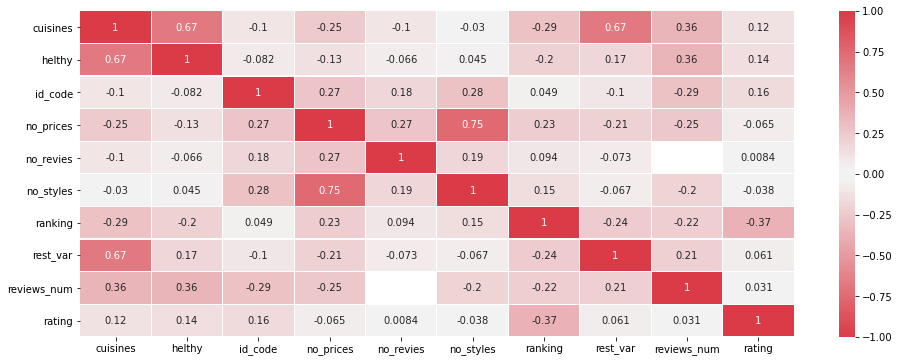

In [42]:
corr_heat(df)

Несмотря на все мои усилия, никакие манипуляции с вектором не принесли существенных результатов, за исключением вектора "helthy", который имеет лучшую корреляцию с рейтнгом (0,13) по сравнению с исходным вектором "cuisines" (количество кухонь всего). Также я пока оставлю вектор "rest_var", несмотря на то, что окореляция у него низкая и улучшить ее я тоже не смог.

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   restaurant_id  50000 non-null  object 
 1   id_ta          50000 non-null  object 
 2   id_code        50000 non-null  int64  
 3   city           50000 non-null  object 
 4   country        50000 non-null  object 
 5   cuisines       50000 non-null  int64  
 6   rest_var       50000 non-null  int64  
 7   helthy         50000 non-null  int64  
 8   cuisine_style  50000 non-null  object 
 9   price_range    32639 non-null  object 
 10  reviews_num    46800 non-null  float64
 11  reviews        49998 non-null  object 
 12  url_ta         50000 non-null  object 
 13  ranking        50000 non-null  float64
 14  rating         50000 non-null  float64
 15  train          50000 non-null  int64  
 16  no_revies      50000 non-null  uint8  
 17  no_prices      50000 non-null  uint8  
 18  no_sty

 - - -  
### 2.4. Вектор price_range  
 - - -  
Мы одновременно преобразуем векор в ординальный вид и заменим пропуск на 2, так как это средний ценовой диапазон, встечающийся чаще всего

In [44]:
# создание нового поля и заполнение пропусков значением 2 (медиана ценовой категории = 2, среднее = 1,88)
df['price_'] = df.price_range.apply(lambda p: 3 if p == '$$$$' else 2 if  p == '$$ - $$$' else 1 if p == '$' else 2)
# "кузнец больше не нужен"
df.drop(['price_range'], axis=1, inplace=True)

In [45]:
# преобразуем вектор price_ - возьмем логарифм - так корреляция увеличивается в 1,5 раза
df['price_log2'] = np.log2(df.price_)
df['price_log'] = np.log(df.price_)

In [46]:
df.columns

Index(['restaurant_id', 'id_ta', 'id_code', 'city', 'country', 'cuisines',
       'rest_var', 'helthy', 'cuisine_style', 'reviews_num', 'reviews',
       'url_ta', 'ranking', 'rating', 'train', 'no_revies', 'no_prices',
       'no_styles', 'price_', 'price_log2', 'price_log'],
      dtype='object')

In [47]:
df = df[['restaurant_id', 'id_ta', 'id_code',
         'city', 'country',
         'cuisines', 'rest_var', 'helthy', 'cuisine_style', 
         'price_', 'price_log', 'price_log2',
         'reviews_num', 'reviews', 
         'url_ta', 'ranking', 
         'rating', 'train',
         'no_revies', 'no_prices', 'no_styles' ]]

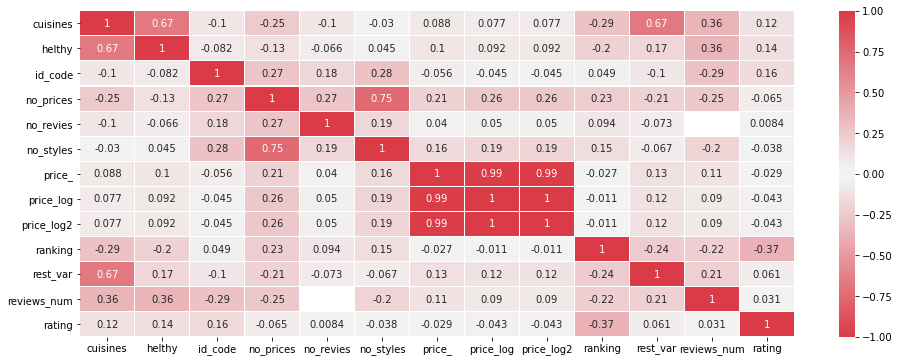

In [48]:
corr_heat(df)

- - -  
### 2.5. Вектор "reviews" и "reviews_num"
- - -  

In [158]:
df[(df.reviews_num > 0) & (df.reviews == '[[], []]')][['reviews_num', 'reviews']]

,reviews_num,reviews
3,3.0,"[[], []]"
10,6.0,"[[], []]"
14,7.0,"[[], []]"
25,2.0,"[[], []]"
29,16.0,"[[], []]"
...,...,...
49978,10.0,"[[], []]"
49984,89.0,"[[], []]"
49989,2.0,"[[], []]"
49997,2.0,"[[], []]"


В датасете неоднозначно заполнены схожие по смыслу поля **reviews_num** и **reviews**. Таблица распределения ниже.  
Бросается в глаза, что в **reviews_num** нет 0 и 1, тогда как поле **reviews** может быть не заполнено, или иметь 1 отзыв. С другой стороны, **reviews_num** может быть заполнено числом, но отзывов самих в соседнем поле нет. А может иметь число большее, чем 1, тем не менее, сам отзыв будет только один.  

reviews_num | reviews | количество записей | Описание
:--- |:--- |:---: |:---
NaN  | '[[], []]' | 1597 | "Количество" не заполнено, и самих отзывов нет - **все совпадает**
NaN  | отзывы  | 946 | "Количество" не заполнено, но сами отзывы есть - **НЕ совпадает**
 \>1 | '[[], []]' | 4868 | Есть не нулевое "Количество" отзывов, но самих отзывов не указано - тоже **НЕ совпадает**
2...986 | 1 отзыв | 4554 | Есть "количество" отзывов, большее 1, но отзыв приведен только один - по-прежнему **НЕ совпадает**
2...9660 | 2 отзыва | 28961 | Ну, и все остальное, где смысл не нарушен, **все совпадает**.


В итоге я прихожу к заключению, что логика заполнение полей не поддается анализу, так как данные противоречивые. Заполнить мне нужно обязательно поле **reviews_num**, так как это числовое поле. Заполнять я его буду по медиане тех записей, у которых не заполнен вектор отзывами (в таблице третья строка = 4868 записей).

In [51]:
# Найдем среднее и медианное значение количества отзывов у тех записей, которые содержат пустой текст отзыва
# в векторе **reviews**
ddf = df[(df.reviews == '[[], []]') & (df.reviews_num >0)][['reviews_num', 'reviews']]
median_nan = ddf.reviews_num.median()
# 6.0
# mean = 12.983155299917831

In [52]:
# !!!
# заменим пустые значения на медиану, как указано выше.
df.reviews_num.fillna(median_nan, inplace=True)
df.reviews_num = df.reviews_num.astype('uint16')

In [54]:
# в тестовой части оказалось две записи с пропусками в векторе "отзывы"
df.reviews.fillna('', inplace=True)

In [55]:
df.isna().sum()

restaurant_id    0
id_ta            0
id_code          0
city             0
country          0
cuisines         0
rest_var         0
helthy           0
cuisine_style    0
price_           0
price_log        0
price_log2       0
reviews_num      0
reviews          0
url_ta           0
ranking          0
rating           0
train            0
no_revies        0
no_prices        0
no_styles        0
dtype: int64

Работа с пропускам закончена. Все векторы заполнены. Приступим к разработке вектора **"reviews"**  
Создам еще два вектора "Полярность отзывов" и "Субъективность отзывов" с помощью библиотеки TextBlob  

In [178]:
# импортирую библиотеку
# !pip install textblob

ERROR: Could not find a version that satisfies the requirement textblob
ERROR: No matching distribution found for textblob


In [56]:
from textblob import TextBlob
#from textblob.sentiments import NaiveBayesAnalyzer

def rev_analise(to_analise):
    blob = TextBlob(to_analise)
    pol = blob.sentiment.polarity
    sub = blob.sentiment.subjectivity

    #blob = TextBlob(to_analise, analyzer=NaiveBayesAnalyzer())
    #test, p_pos, p_neg = blob.sentiment
    return pd.Series([pol , sub]) #, test, p_pos, p_neg ])

In [57]:
df[['polarity', 'subjectivity']] = df.reviews.apply(rev_analise)

#### Поработаем с датами отзывов

In [58]:
# получение дат последних отзывов и сохранение их в новых полях
pattern = re.compile('\'\d+\/\d+\/\d+\'')

dates = df.reviews.apply(pattern.findall)

df['date1']=pd.to_datetime(dates.apply(lambda q: q[0] if len(q)>0 else None))
df['date2']=pd.to_datetime(dates.apply(lambda q: q[1] if len(q)>1 else None))
df['dates']=pd.to_numeric(dates.apply(lambda q: 2 if len(q)>1 else 1 if len(q)>0 else 0))

In [59]:
# разница между датами по модулю
df['date_dif'] = (df.date1 - df.date2).dt.days
df.date_dif.fillna(0, inplace=True)
#df.date_dif = np.log(df.date_dif.abs())

first= pd.Timestamp('2019-01-01')

df['date_per'] = np.log((first - df.date2).dt.days)
df.date_per.fillna(0, inplace=True)

#Заполнение пропусков у дат на 0
#df.date1.fillna(0, inplace=True)
#df.date2.fillna(0, inplace=True)

In [60]:
#
df['month']= df.date1.dt.month
#df.date1.apply(lambda q: q.dt.month if q>0 else np.nan)
df['yeartime'] = df.month.apply(lambda q: "winter" if q>11 else "autumn" if q>8 
                                else "summer" if q> 5 else "spring" if q>2 else "winter" if q>0 else "no")

In [61]:
get_stat_dif('yeartime')

Найдены статистически значимые различия для колонки yeartime


In [62]:
df['year']= df.date1.dt.year - 2018
get_stat_dif('year')

Найдены статистически значимые различия для колонки year


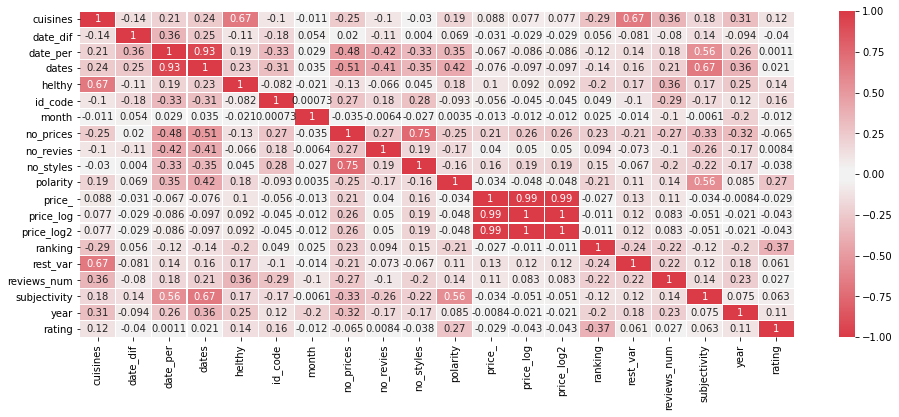

In [63]:
corr_heat(df)

In [64]:
df = df[['restaurant_id', 'id_ta', 'id_code',
         'city', 'country', 'cuisines', 'rest_var', 'helthy', 'cuisine_style', 
         'price_', 'price_log', 'price_log2',
         'reviews_num',
         'reviews', 'polarity', 'subjectivity', 
         'dates', 'date1', 'date2','date_dif', 'date_per', 'month', 'yeartime', 'year',
         'url_ta', 'ranking', 'rating', 'train',
         'no_revies', 'no_prices','no_styles']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   restaurant_id  50000 non-null  object        
 1   id_ta          50000 non-null  object        
 2   id_code        50000 non-null  int64         
 3   city           50000 non-null  object        
 4   country        50000 non-null  object        
 5   cuisines       50000 non-null  int64         
 6   rest_var       50000 non-null  int64         
 7   helthy         50000 non-null  int64         
 8   cuisine_style  50000 non-null  object        
 9   price_         50000 non-null  int64         
 10  price_log      50000 non-null  float64       
 11  price_log2     50000 non-null  float64       
 12  reviews_num    50000 non-null  uint16        
 13  reviews        50000 non-null  object        
 14  polarity       50000 non-null  float64       
 15  subjectivity   5000

In [65]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

"Нормализуем" векторы "количество отзывов" и "ранг"

In [66]:
df.insert(13, 'normal_reviews', -1)
df.insert(27, 'normal_rank', -1)

for city in df.city.unique():
    df_ = df.loc[df.city == city].copy()
    scaler_s = StandardScaler()
    res = np.array(scaler_s.fit_transform(np.array(df_.reviews_num).reshape(-1, 1)))
    df.loc[df.city == city, 'normal_reviews'] = pd.Series(res.flatten(), df_.index)

    res = np.array(scaler_s.fit_transform(np.array(df_.ranking).reshape(-1, 1)))
    df.loc[df.city == city, 'normal_rank'] = pd.Series(res.flatten(), df_.index)
    
    

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   restaurant_id   50000 non-null  object        
 1   id_ta           50000 non-null  object        
 2   id_code         50000 non-null  int64         
 3   city            50000 non-null  object        
 4   country         50000 non-null  object        
 5   cuisines        50000 non-null  int64         
 6   rest_var        50000 non-null  int64         
 7   helthy          50000 non-null  int64         
 8   cuisine_style   50000 non-null  object        
 9   price_          50000 non-null  int64         
 10  price_log       50000 non-null  float64       
 11  price_log2      50000 non-null  float64       
 12  normal_reviews  50000 non-null  float64       
 13  reviews_num     50000 non-null  uint16        
 14  reviews         50000 non-null  object        
 15  po

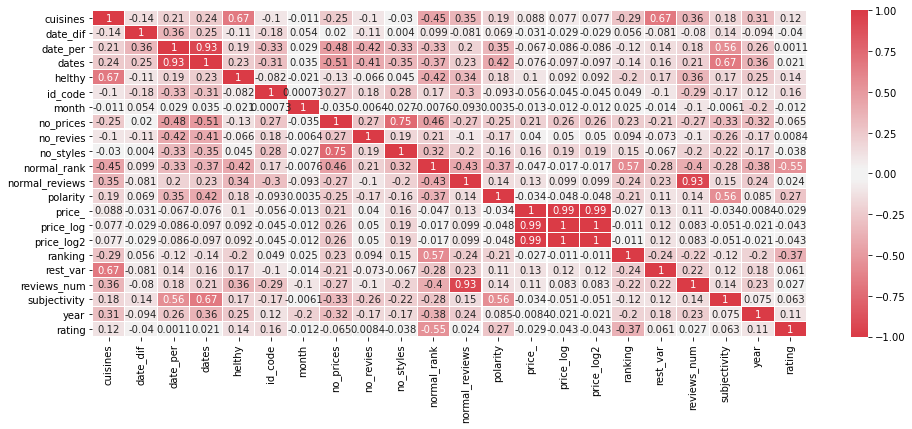

In [68]:
corr_heat(df)

# # MAE & FE

In [69]:
df.date1.fillna(0, inplace=True)
df.date2.fillna(0, inplace=True)
df.month.fillna(0, inplace=True)
df.year.fillna(0, inplace=True)
df.yeartime.fillna(0, inplace=True)
df.isna().sum()

restaurant_id     0
id_ta             0
id_code           0
city              0
country           0
cuisines          0
rest_var          0
helthy            0
cuisine_style     0
price_            0
price_log         0
price_log2        0
normal_reviews    0
reviews_num       0
reviews           0
polarity          0
subjectivity      0
dates             0
date1             0
date2             0
date_dif          0
date_per          0
month             0
yeartime          0
year              0
url_ta            0
normal_rank       0
ranking           0
rating            0
train             0
no_revies         0
no_prices         0
no_styles         0
dtype: int64

,object,drop,MAE_0,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5
0,restaurant_id,,ci_Amsterdam,ci_Geneva,ci_Milan,ci_Zurich,no_styles,subjectivity
1,id_ta,,ci_Athens,ci_Hamburg,ci_Munich,cuisines,normal_rank,train
2,city,,ci_Barcelona,ci_Helsinki,ci_Oporto,date_dif,normal_reviews,year
3,country,,ci_Berlin,ci_Krakow,ci_Oslo,date_per,polarity,rating
4,cuisine_style,,ci_Bratislava,ci_Lisbon,ci_Paris,dates,price_,
5,reviews,,ci_Brussels,ci_Ljubljana,ci_Prague,helthy,price_log,
6,date1,,ci_Budapest,ci_London,ci_Rome,id_code,price_log2,
7,date2,,ci_Copenhagen,ci_Luxembourg,ci_Stockholm,month,ranking,
8,yeartime,,ci_Dublin,ci_Lyon,ci_Vienna,no_prices,rest_var,
9,url_ta,,ci_Edinburgh,ci_Madrid,ci_Warsaw,no_revies,reviews_num,


 MAE : 0.20008249999999997, MAE_rounded: 0.16585


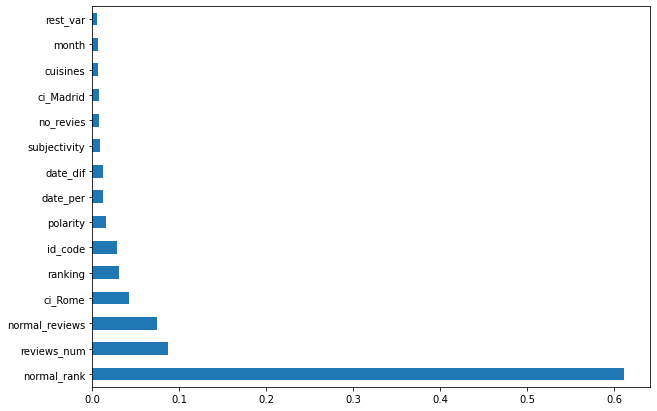

In [70]:
df1=df.copy()
df1 = dum_on(df1,'city')

test_vector(df1,[])
#  MAE : 0.2017298649324662, MAE_rounded: 0.16543271635817908
#  MAE : 0.20155927963981993, MAE_rounded: 0.16588294147073537

# MAE : 0.20008249999999997, MAE_rounded: 0.16585

In [71]:
# Добавим векторы 
df['reviews_sum'] = np.nan                                          # сумма ревью по городу
df.reviews_sum = df.groupby('city').reviews_num.transform('sum')
df['reviews_rate'] = df.reviews_num / df.reviews_sum                # доля ревью по ресторану от суммы по городу

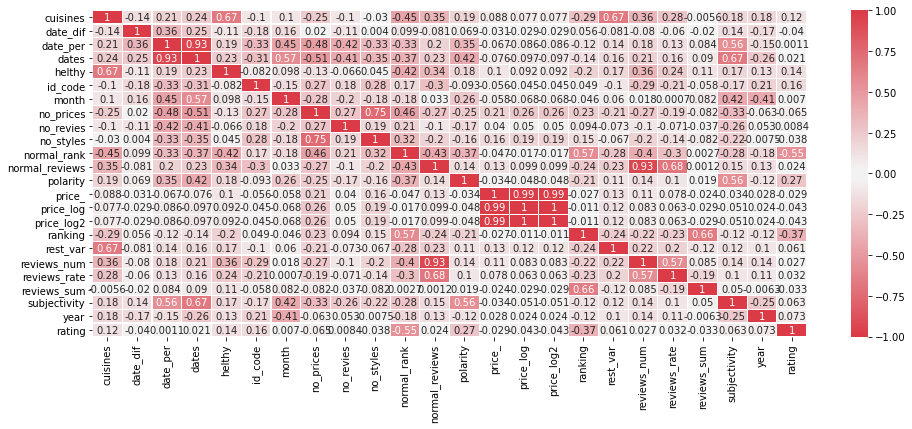

In [72]:
corr_heat(df)

,object,drop,MAE_0,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5
0,restaurant_id,reviews_rate,ci_Amsterdam,ci_Geneva,ci_Milan,ci_Zurich,no_styles,reviews_sum
1,id_ta,,ci_Athens,ci_Hamburg,ci_Munich,cuisines,normal_rank,subjectivity
2,city,,ci_Barcelona,ci_Helsinki,ci_Oporto,date_dif,normal_reviews,train
3,country,,ci_Berlin,ci_Krakow,ci_Oslo,date_per,polarity,year
4,cuisine_style,,ci_Bratislava,ci_Lisbon,ci_Paris,dates,price_,rating
5,reviews,,ci_Brussels,ci_Ljubljana,ci_Prague,helthy,price_log,
6,date1,,ci_Budapest,ci_London,ci_Rome,id_code,price_log2,
7,date2,,ci_Copenhagen,ci_Luxembourg,ci_Stockholm,month,ranking,
8,yeartime,,ci_Dublin,ci_Lyon,ci_Vienna,no_prices,rest_var,
9,url_ta,,ci_Edinburgh,ci_Madrid,ci_Warsaw,no_revies,reviews_num,


 MAE : 0.1999565, MAE_rounded: 0.16595


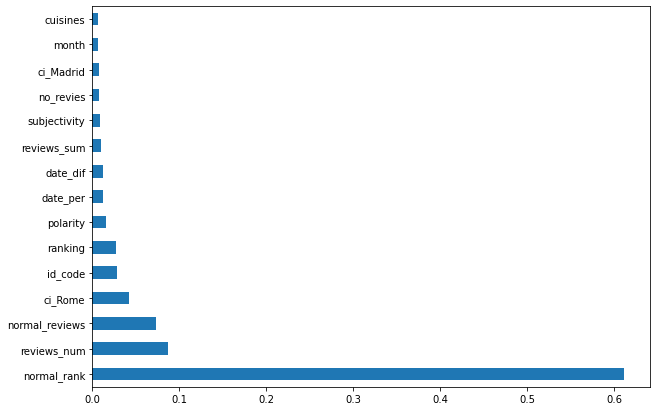

In [75]:
df1=df.copy()
df1 = dum_on(df1,'city')

test_vector(df1,[])
#  MAE : 0.2013171585792896, MAE_rounded: 0.16528264132066034           'reviews_sum'
# MAE : 0.20125512756378186, MAE_rounded: 0.1655327663831916
# MAE : 0.20163181590795395, MAE_rounded: 0.16548274137068533           'reviews_sum'
# MAE : 0.20094747373686841, MAE_rounded: 0.16508254127063532            'reviews_rate'

# MAE : 0.19917799999999997, MAE_rounded: 0.1653
        

Вектор "reviews_rate" оказался менее полезным для модели, так что его пока исключим

upd а в другой день - все векторы оказались полезными

In [70]:
df.drop(['reviews_rate'], axis=1, inplace=True)

In [76]:
# Добавим вектор "количество злачных мест в городе" - places_city
df['places_city'] = np.nan
df.places_city = df.groupby('city').id_ta.transform('count')

,object,drop,MAE_0,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5
0,restaurant_id,places_city,ci_Amsterdam,ci_Geneva,ci_Milan,ci_Zurich,no_styles,reviews_rate
1,id_ta,,ci_Athens,ci_Hamburg,ci_Munich,cuisines,normal_rank,reviews_sum
2,city,,ci_Barcelona,ci_Helsinki,ci_Oporto,date_dif,normal_reviews,subjectivity
3,country,,ci_Berlin,ci_Krakow,ci_Oslo,date_per,polarity,train
4,cuisine_style,,ci_Bratislava,ci_Lisbon,ci_Paris,dates,price_,year
5,reviews,,ci_Brussels,ci_Ljubljana,ci_Prague,helthy,price_log,rating
6,date1,,ci_Budapest,ci_London,ci_Rome,id_code,price_log2,
7,date2,,ci_Copenhagen,ci_Luxembourg,ci_Stockholm,month,ranking,
8,yeartime,,ci_Dublin,ci_Lyon,ci_Vienna,no_prices,rest_var,
9,url_ta,,ci_Edinburgh,ci_Madrid,ci_Warsaw,no_revies,reviews_num,


 MAE : 0.19917799999999997, MAE_rounded: 0.1653


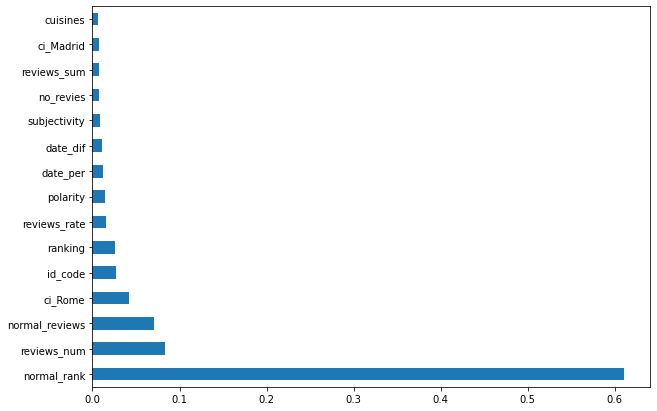

In [79]:
df1=df.copy()
df1 = dum_on(df1,'city')

test_vector(df1,['places_city'])  #'price_', 'no_styles'
#   MAE : 0.2013171585792896, MAE_rounded: 0.16528264132066034            'reviews_sum', 'places_city'
#  МАЕ : 0.20174287143571787, MAE_rounded: 0.16578289144572286             'reviews_sum', 'places_city'
#  MAE : 0.20109504752376184, MAE_rounded: 0.1648824412206103

# MAE : 0.19950500000000002, MAE_rounded: 0.16625 
# MAE : 0.19917799999999997, MAE_rounded: 0.1653

In [80]:
# Добавим вектор "
df['cuisines_city'] = np.nan
#df.cuisines_city = df.groupby('city').cuisines.transform('mean')

In [81]:
# Посчитаем широту представленности кухонь в каждом городе и создадим словарь
cuisines_in_place = {}
cities=df.city.unique().tolist()
for city in cities:
    add = len(df[df.city == city].cuisine_style.explode().value_counts().index.tolist())
    cuisines_in_place.update({city: add})
df.cuisines_city = df.city.map(cuisines_in_place)

,object,drop,MAE_0,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5
0,restaurant_id,places_city,ci_Amsterdam,ci_Geneva,ci_Milan,ci_Zurich,no_styles,subjectivity
1,id_ta,cuisines_city,ci_Athens,ci_Hamburg,ci_Munich,cuisines,normal_rank,train
2,city,price_log,ci_Barcelona,ci_Helsinki,ci_Oporto,date_dif,normal_reviews,year
3,country,price_log2,ci_Berlin,ci_Krakow,ci_Oslo,date_per,polarity,rating
4,cuisine_style,,ci_Bratislava,ci_Lisbon,ci_Paris,dates,price_,
5,reviews,,ci_Brussels,ci_Ljubljana,ci_Prague,helthy,ranking,
6,date1,,ci_Budapest,ci_London,ci_Rome,id_code,rest_var,
7,date2,,ci_Copenhagen,ci_Luxembourg,ci_Stockholm,month,reviews_num,
8,yeartime,,ci_Dublin,ci_Lyon,ci_Vienna,no_prices,reviews_rate,
9,url_ta,,ci_Edinburgh,ci_Madrid,ci_Warsaw,no_revies,reviews_sum,


 MAE : 0.199512, MAE_rounded: 0.1653


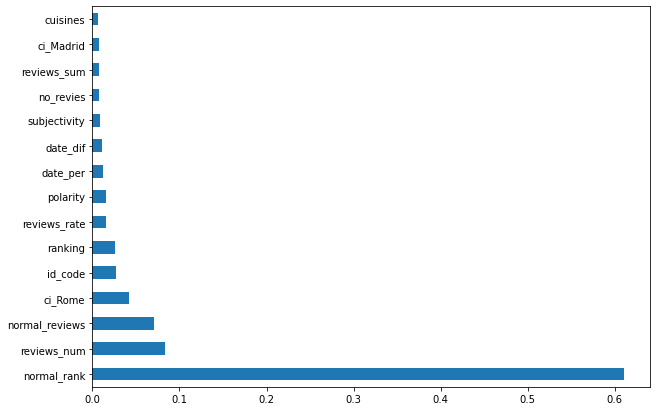

In [103]:
df1=df.copy()
df1 = dum_on(df1,'city')   
#df1 = dum_on(df1,'yeartime') # MAE_rounded: 0.1655327663831916  vc 0.16418209104552275


test_vector(df1,['places_city', 'cuisines_city', 'price_log', 'price_log2'])
# MAE : 0.2010670335167584, MAE_rounded: 0.1656328164082041
# MAE : 0.20101900950475238, MAE_rounded: 0.16543271635817908   'dates', 'no_styles'
# MAE : 0.20047423711855927, MAE_rounded: 0.16418209104552275   'dates', 'no_styles', 'subjectivity'
# MAE : 0.20058129064532265, MAE_rounded: 0.16493246623...   'dates', 'no_styles', 'subjectivity', 'price_log2'
# MAE : 0.20065932966483244, MAE_rounded: 0.1643821910....  'dates', 'no_styles', 'subjectivity', 'price_'
# MAE : 0.20084592296148074, MAE_rounded: 0.1655327663...   'dates', 'no_styles', 'subjectivity', 'price_', 'price_log'
# MAE : 0.20283091545772888, MAE_rounded: 0.1676838419...   'dates', 'no_styles', 'subjectivity', 'no_revies'

# MAE : 0.20054627313656828, MAE_rounded: 0.16523261630815408    'dates', 'no_styles', 'subjectivity'
# MAE : 0.20090495247623813, MAE_rounded: 0.1657328664332166
# MAE : 0.20109504752376184, MAE_rounded: 0.1648824412206103      'cuisines_city'
# MAE : 0.20103001500750375, MAE_rounded: 0.1647823911955978       'cuisines_city', 'dates'        dum 'yeartime'

#  MAE : 0.19966599999999998, MAE_rounded: 0.16685  'places_city', 'cuisines_city', 'price_log', 'price_log2', 'no_prices'
#  MAE : 0.199632, MAE_rounded: 0.1661      'places_city', 'cuisines_city', 'price_log', 'price_log2', 'reviews_sum'
#  MAE : 0.199512, MAE_rounded: 0.1653      'places_city', 'cuisines_city', 'price_log', 'price_log2'


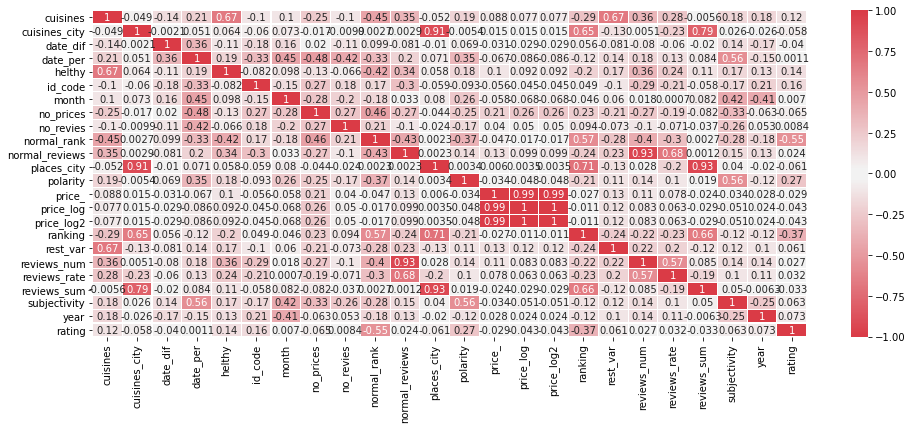

In [93]:
#df.drop(['places_city', 'reviews_sum'], axis=1, inplace=True)
corr_heat(df, ['no_styles', 'dates'])

MAE        : 0.199512
MAE rounded: 0.1653


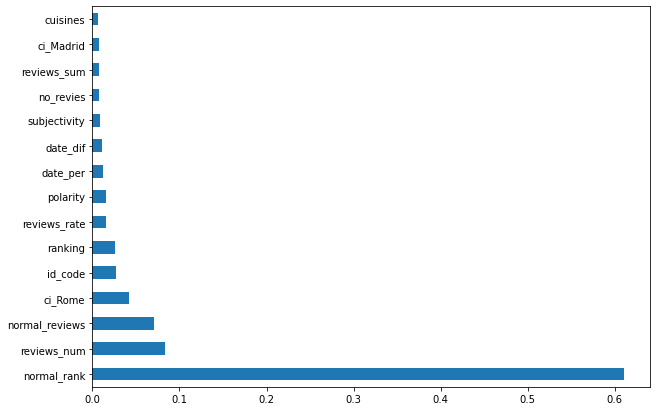

In [107]:
df_ready = df.copy()
df_ready.drop(['places_city', 'cuisines_city', 'price_log', 'price_log2'], axis=1, inplace=True)
df_ready = dum_on(df_ready,'city')   

list_col = df_ready.columns.tolist()                                                    # все векторы
list_obj = df_ready.select_dtypes(include=['object', 'datetime64']).columns.to_list()   # векторы не числовые
list_drop = []                                                            # векторы для удаления вручную
    
    # создаем итоговый set векторов для модели
list_mae = list(set(list_col) - set(list_obj) - set(list_drop))
list_mae = sorted(list_mae)
list_mae.remove('rating')
list_mae.append('rating')                                                           # вектор "рейтинг" ставим в конце

mae, mae_round, test_data = mae_test(df_ready[list_mae])

print(f'MAE        : {mae}')
print(f'MAE rounded: {mae_round}')

# ИТОГ
- - - 
подготовим файл для загрузки результата на Kaggle

PS. Я возможно, еще попробую улучшить результат, если мне помогут, или у меня появится еще идея. 

In [120]:
df_ready_test = df_ready.query('train == 0').drop(['train'], axis=1)
df_ready_test['y_t'] = test_data['rating']
#df_ready_test.info()
df_ready_test = df_ready_test[['restaurant_id', 'y_t']]
df_ready_test.columns= ['Restaurant_id', 'Rating']
df_ready_test.to_csv('submission.csv', index=False)
df_ready_test

,Restaurant_id,Rating
40000,id_0,3.0
40001,id_1,4.5
40002,id_2,4.5
40003,id_3,4.5
40004,id_4,4.5
...,...,...
49995,id_9995,4.5
49996,id_9996,4.0
49997,id_9997,3.0
49998,id_9998,4.5


# Нудачи
- - - 

Было много векторов, которые в итоге не пошли в модель. Их я удалил, чтобы не засорять код. Надо сказать, что ни страна, ни время года не принесли видимого результата для модели.  
Страна, пожалуй, только позволила создавать  новые вектора на основе  аггрегирования для сумм или подсчета количества.  

# что не удалось

Жаль, что не удалось запустить функцию TextBlob, для анализа на позитивность и негативность. А создавать свою на основе ручного сета слов, у меня не хватило желания.  

Все еще не доволен я чистотой кода, синтаксис - это наверняка то, что тут много где можно поправить.

# Неожиданно.

Вектор resaurant_id это почти 100% реплика вектора ranking. Точнее, наверное нужно скзать, что РАНГ - это реплика вектора КОД_РЕСТОРАНА. Более чем в 2/3 случаев они отличаются на 1-2 пункта. А корреляция этих векторов равна 1. Понятно, что c этим вектором нам ничего не светит для модели. Но как он тут оказался - загадка! 